# **Open Data Examples** | Recreation Access and Optimal Locations
This notebook will walk you through the following:
1. Downloading and inspecting the City's park amenities data from Open Data. These are playgrounds, swingsets, and other features of every park.
2. Downloading the City's census population data, filtering out only Cleveland.
3. Analysis of spatial proximity and coverage of City population to specific amenity types
4. Spatial optimization for new facility: "If we can build one playground, where can it be located to be near the most kids?"

To run this notebook, you will need to install the following packages using `pip`:
* `arcgis` - The main API for fetching the data off Esri web GIS services
* `cle-data-toolkit` - Our public Python package with helper functions
* `pysal` - Helpers for spatial analysis
* `contextily` - For basemaps to give our maps reference

In [2]:
# Import our packages
from arcgis import GIS
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from libpysal.weights import Rook

In [38]:
# Create a GIS object that connects to ArcGIS Online, which hosts all the City's Open Data datasets and more
gis = GIS()

# The City's Open Data Portal is contained within a "group" in ArcGIS Online. This is the group's ID.
open_data_id ='6dfff98aa5314c84bc10567e86a90d88'

# Search for the exact title of the parks & rec layer. Select the first and only result.
parks_service = gis.content.search("title:Cleveland Parks and Recreation System")[0]
parks_service

<Item title:"Cleveland Parks and Recreation System" type:Feature Layer Collection owner:jrauschenbach_ago>

In [6]:
# Feature services are like servers that can broadcast one or more datasets.
for idx, lyr in enumerate(parks_service.layers): # Cycle through all layers in the `layers` property of the item
    print(idx, lyr.properties['name'])

0 Cleveland Recreation Centers
1 Cleveland Park Amenities
2 Cleveland Recreation Center Outdoor Amenities
3 Cleveland Parks


In [10]:
# Pick the "Park Amenities" feature layer, which is index 1
amenities_layer = parks_service.layers[1]
# Query the layer for all its records
amenities_featureset = amenities_layer.query()
# Convert the set to GeoJSON
amenities_geojson = amenities_featureset.to_geojson
# Convert the GeoJSON to a geopandas Geoataframe using Ohio North projection EPSG 3734
amenities_gdf = gpd.read_file(amenities_geojson, driver="GeoJSON", crs="EPSG:3734").set_crs(epsg=3734, allow_override=True)

In [11]:
# Let's learn about the most common park amenities in our dataset
(amenities_gdf
 .Amenity_Type # Access the `Amenity_Type` column as a property
 .value_counts(ascending=False)) # Get counts of all unique values of that column from highest to lowest

Amenity_Type
Swing Set                     159
Diamond Field                 105
Playground                    103
Basketball Court               99
Tennis Court                   63
Parking Lot                    60
Multi-Purpose Field            55
Aquatics Playground            46
Shelter                        44
Community Garden               40
Exercise Equipment Station     36
Restroom                       25
Loop Trail                     24
Outdoor Swimming Pool          20
Horseshoe Pit                  17
Rectangle Field                12
Grill                          11
Pickelball Court Overlay        7
Outdoor Waterslide              6
Sand Volleyball Court           4
Amphitheatre                    4
Concession Stand                4
Bocce Ball Court                3
BMX or Pump Track               3
Running Track                   3
Tennis Practice Wall            3
Dog Park                        2
Rugby Field                     1
Futsal Court                    1
C

## Population Data
### To breakdown park amenity access across Cleveland population, we need detailed demographic data.
Esri curates a collection of geographic data across the world, called the *Living Atlas*. The Living Atlas includes free and public data services from trusted common sources, and hosted on ArcGIS Onlinein the same data service format at Open Data. They are accessible in the ArcGIS API we use and through ArcGIS Online.

The U.S. Census Bureau's *Demographic and Housing Characteristics* dataset is offered on living. This is a good source for this analysis because it:
* Breaks down population by specific age groups. We are interested in younger Clevelanders.
* Has no margins of error because it's based on a full count.
* Offers granular data all the way down to block. The results would not be as precise or useful if we consider tracts or county-level data.

In [18]:
# Search for the exact title of the data, sort by number of views
census_item = gis.content.search("title:USA 2020 Census Population Characteristics, owner:esri_demographics", sort_field="numViews")[0]
census_item

<Item title:"USA 2020 Census Population Characteristics" type:Feature Layer Collection owner:esri_demographics>

In [19]:
# Lets see what layers this service offers. This will print all the layers offered in this service.
for idx, lyr in enumerate(census_item.layers): # Cycle through all layers in the `layers` property of the item
    print(idx, lyr.properties['name'])

0 Nation
1 State
2 County
3 Census Tract
4 Block Group


In [23]:
# We want the most granular data possible, block groups.
blockgroup_census = census_item.layers[4]
# Query the layer block groups in Cuyahoga County
bg_fs = blockgroup_census.query(where="County = 'Cuyahoga County'", return_all_records=True)
# Convert to GeoJSON
bg_gjson = bg_fs.to_geojson
# Read to GeoDataFrame, project to Ohio North so we have clean reliable measurements
bg_gdf = gpd.read_file(bg_gjson, driver="GeoJSON", crs="EPSG:3857").set_crs(epsg=3857, allow_override=True).to_crs(epsg=3734)

### Clean up field names
The Census data comes with raw variable names that require reference material to decipher.  
Part of Esri's curation is providing human-friendly aliases for each field and other calculations. **We need to pull those aliases out and rename our columns.**

In [26]:
field_map = {}
for fld_dict in blockgroup_census.properties['fields']: # The `properties` attribute has a `fields` list we will iterate through
    field_map[fld_dict['name']] = fld_dict['alias'] # Each field has an alias, that's what we want!
field_map

{'OBJECTID': 'Object ID',
 'GEOID': 'Geographic Identifier',
 'ALAND': 'Area of Land (Square Meters)',
 'AWATER': 'Area of Water (Square Meters)',
 'INTPTLAT': 'Current latitude of the internal point',
 'INTPTLON': 'Current longitude of the internal point',
 'NAME': 'Name',
 'State': 'State',
 'County': 'County',
 'P0010001': 'Total Population',
 'H0010001': 'Total Housing Units',
 'H0030002': 'Total Households (Occupied Housing Units)',
 'P001_calc_pctPopDensity': 'Population Density (people per square kilometer)',
 'P0020002': 'Urban population',
 'P0020003': 'Rural population',
 'P0020004': 'Population for whom urban and rural is not defined',
 'P002_calc_pct0002': 'Percent of population that is urban',
 'P002_calc_pct0003': 'Percent of population that is rural',
 'P0030002': 'Population who is White alone',
 'P0030003': 'Population who is Black or African American alone',
 'P0030004': 'Population who is American Indian and Alaska Native alone',
 'P0030005': 'Population who is Asian

In [35]:
# Rename the columns with the `field_map` dictionary made above
bg_gdf = bg_gdf.rename(columns=field_map)
bg_gdf

,Object ID,Geographic Identifier,Area of Land (Square Meters),Area of Water (Square Meters),Current latitude of the internal point,Current longitude of the internal point,Name,State,County,Total Population,...,Population in group quarters,Population in institutionalized group quarters,Population in noninstitutionalized group quarters,Percent of population living in households,Percent of population living in group quarters,Minors in households,People living alone (1-person households),Shape Area,Shape Length,geometry
0,216465,390351011011,180565,0,+41.4822027,-81.7457946,Block Group 1,Ohio,Cuyahoga County,918,...,118,87,31,87.1,12.9,171,146,3.219884e+05,2226.664102,"POLYGON ((2175866.166 661802.020, 2175807.713 ..."
1,216466,390351011012,125424,0,+41.4810483,-81.7513018,Block Group 2,Ohio,Cuyahoga County,768,...,0,0,0,100.0,0.0,88,330,2.236552e+05,2223.994346,"POLYGON ((2174407.748 661589.728, 2174127.484 ..."
2,216467,390351011021,247177,0,+41.4849215,-81.7527171,Block Group 1,Ohio,Cuyahoga County,1373,...,0,0,0,100.0,0.0,60,634,4.408125e+05,4187.734384,"POLYGON ((2173434.755 663659.793, 2174968.683 ..."
3,216468,390351011022,313215,0,+41.4835009,-81.7569434,Block Group 2,Ohio,Cuyahoga County,1079,...,0,0,0,100.0,0.0,97,305,5.585626e+05,3141.040896,"POLYGON ((2173561.673 662280.242, 2172701.481 ..."
4,216469,390351011023,183081,0,+41.4854773,-81.7650042,Block Group 3,Ohio,Cuyahoga County,717,...,3,0,3,99.6,0.4,77,229,3.265093e+05,2467.040345,"POLYGON ((2170967.584 663736.414, 2170905.679 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,217644,390359802001,617091,1258841,+41.4863591,-81.7447489,Block Group 1,Ohio,Cuyahoga County,0,...,0,0,0,NaN,NaN,0,0,1.100644e+06,6534.703666,"POLYGON ((2179346.989 665999.188, 2179349.373 ..."
1180,217645,390359805001,7923030,0,+41.4056422,-81.8526903,Block Group 1,Ohio,Cuyahoga County,3,...,0,0,0,100.0,0.0,1,0,1.409566e+07,20834.386629,"POLYGON ((2152030.412 638997.623, 2152036.587 ..."
1181,217646,390359809001,1098921,0,+41.5695252,-81.5638942,Block Group 1,Ohio,Cuyahoga County,0,...,0,0,0,NaN,NaN,0,0,1.964910e+06,8315.910031,"POLYGON ((2228735.654 696607.328, 2228669.376 ..."
1182,217647,390359810001,3333841,683,+41.4721759,-81.4948695,Block Group 1,Ohio,Cuyahoga County,54,...,48,48,0,11.1,88.9,2,1,5.942463e+06,16130.820672,"POLYGON ((2245781.953 656320.743, 2245771.761 ..."


### Reference boundaries for City of Cleveland
To improve our mapping and provide context, we can quickly grab City boundaries and City neighborhoods from Open Data.

In [64]:
# Fetching City Boundary
city_boundary_item = gis.content.search("title:'City of Cleveland Boundary' owner:clevelandGISAGO")[0]
city_gjson = city_boundary_item.layers[0].query().to_geojson
city_gdf = gpd.read_file(city_gjson, driver="GeoJSON", crs="EPSG:3734").set_crs(epsg=3734, allow_override=True)

# Fetching City Boundary
city_neighborhoods_item = gis.content.search("title:'Cleveland Neighborhoods' owner:jot_hall")[0]
hoods_gjson = city_neighborhoods_item.layers[0].query().to_geojson
hoods_gdf = gpd.read_file(hoods_gjson2, driver="GeoJSON", crs="EPSG:3734").set_crs(epsg=3734, allow_override=True)

In [15]:
# Subset of Cuyahoga County block groups that have representative points spatially within the City polygon
# Representative points are guaranteed to be inside the block groups. Centroids can technically fall outside for doughnut shapes, e.g. near the airport
cle_bgs = (bg_gdf[bg_gdf
                      .geometry
                      .representative_point()
                      .intersects(city_gdf.geometry.iloc[0])]
                      .copy()) # Copy so we can modify this in place

<Axes: >

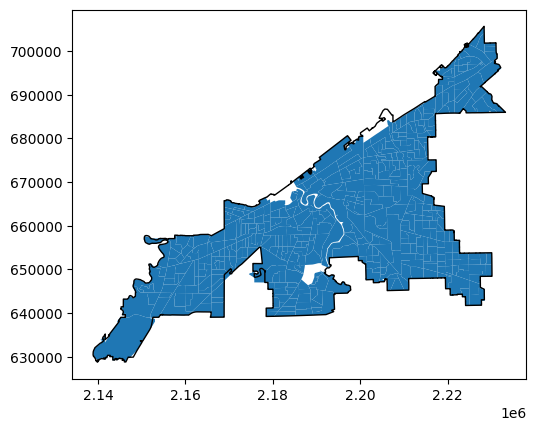

In [16]:
# Let's check how we did. The blue block groups should all be inside our city Boundary
fig, ax = plt.subplots()
cle_bgs.plot(ax=ax)
city_gdf.plot(ax=ax, facecolor='none', edgecolor='black')

In [17]:
# Our primary spatial function, which checks whether a type of amenity is within our buffer distance
# It creates a new column in the given dataframe with a Series of boolean values.
# True = the block group's center is within range, False = the block groups' center is not within range

buffer_distance = 2640 # Half mile in feet
def access_evaluator(access_name, pop_gdf, points_gdf):
    buffer_amenity = points_gdf[points_gdf.Amenity_Type == access_name].buffer(2640).unary_union
    pop_gdf[access_name+"_flag"] = buffer_amenity.intersects(pop_gdf.geometry.representative_point())

In [18]:
# Evaluate each amenity using the function above
for amenity in amenities_gdf.Amenity_Type.unique():
    access_evaluator(amenity, cle_bgs, amenities_gdf)

In [19]:
# Exploring our distribution of flags by each amenity type.
n= 12
top_n = amenities_gdf.Amenity_Type.value_counts(ascending=False).index.to_list()[:n]

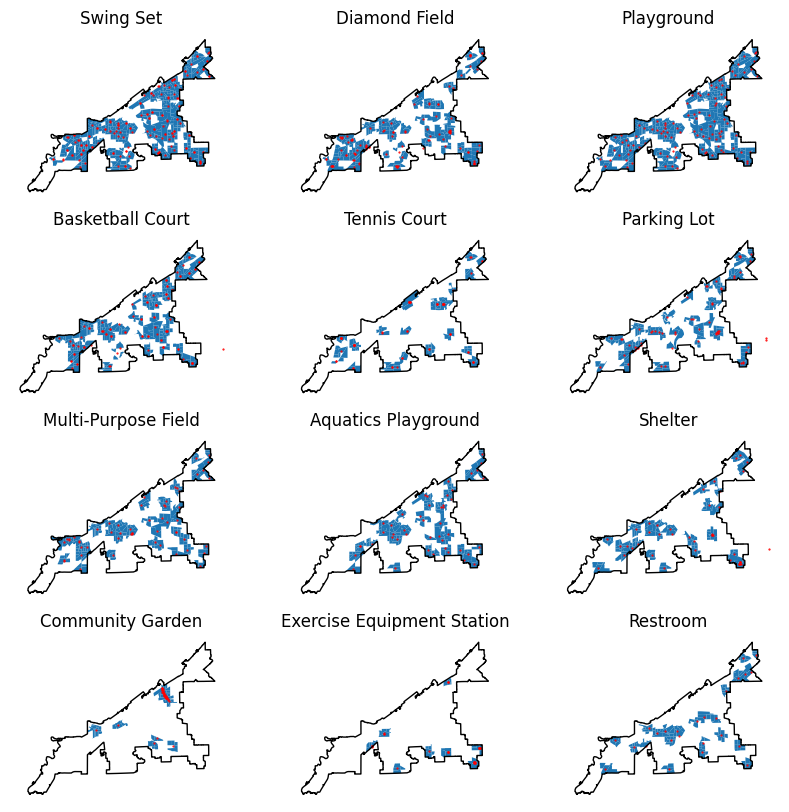

In [20]:
cols, rows = 3,4  #num of subplots <= (cols x rows)
# Create matplotlib figure with an array of axes to plot on
fig, axs = plt.subplots(nrows=rows, ncols=cols)
# Make it larger so we can fit more map
fig.set_size_inches(10,10)

# Iterate through our most frequent amenities 
count = 0
for irow in range(axs.shape[0]):
    for icol in range(axs.shape[1]):
            amenity = top_n[count]
            cle_bgs[ cle_bgs[amenity+"_flag"] == True].plot(ax=axs[irow][icol])
            amenities_gdf[amenities_gdf.Amenity_Type ==  amenity].plot(ax=axs[irow][icol], color='red', markersize=.3)
            city_gdf.plot(ax=axs[irow][icol], facecolor='none', edgecolor='black')
            axs[irow][icol].set_title(amenity)
            axs[irow][icol].set_axis_off()
            count += 1

In [68]:
# Let's use these true/false flags to produce summary statistics
# We want to learn about what percent of different populations are within range of these amenities
# To do this we will need to transform our dataset using groupby and aggregations

# Define the list of Census fields we want to iterate through
demographic_groups = ['Population under 18 years']

# Set up a loop that will perform calculations for each column above
out_list = []
for amenity in amenities_gdf.Amenity_Type.unique(): # For each unique amenity
    report_outs = []
    for fld in demographic_groups: # For each demographic group we listed
        try:
            # Sum the number of people in that group that have value True for access to that amenity
            number_covered =cle_bgs.groupby(f'{amenity}_flag').agg({fld:'sum'}).loc[True].iloc[0] 
            # Sum total number of people in that group
            total_possible = cle_bgs[fld].sum()
            # Divide with access over total number
            percent_covered = (100 * number_covered) / total_possible
        except:
            # If there is not True index, that means nobody has access, return 0
            percent_covered = 0
        # Append these figures to the array for this amenity
        report_outs.append(percent_covered)
    # Append this amenity + report outs to the outbound list
    out_list.append([amenity, *report_outs])

# Create a dataframe from the results
# Add % within 1/2 mile to each group column
access_summary = pd.DataFrame(out_list, columns=['Amenity', *[grp + " % within 1/2 mile" for grp in demographic_groups]])

Text(0.5, 1.0, 'Proximity to City Park Amenities using Open Data')

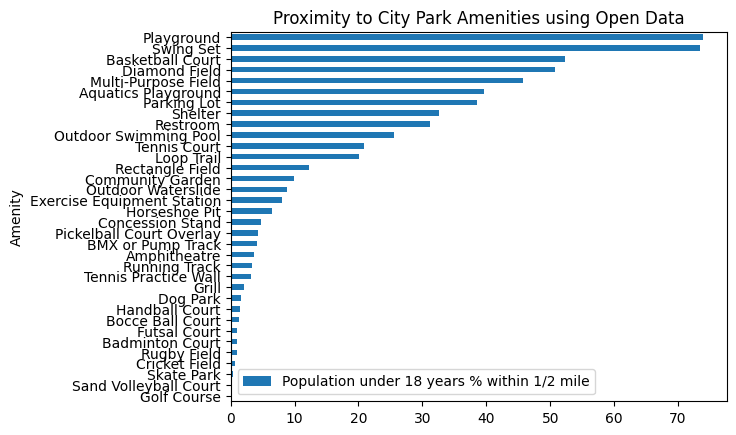

In [70]:
access_summary.set_index('Amenity').sort_values('Population under 18 years % within 1/2 mile').plot.barh()
plt.title('Proximity to City Park Amenities using Open Data')

### We now better understand access for Cleveland's under 18 population across all park amenities from the Open Data layer.  

Some amenities are essential and need to be nearer for access; others are occasional visits that can be further. Let's set a goal for 100% coverage of playgrounds within 1/2 mile of all minors in Cleveland.

**If we had to pick only 1 location, how can we use the data to make the most impactful change?**

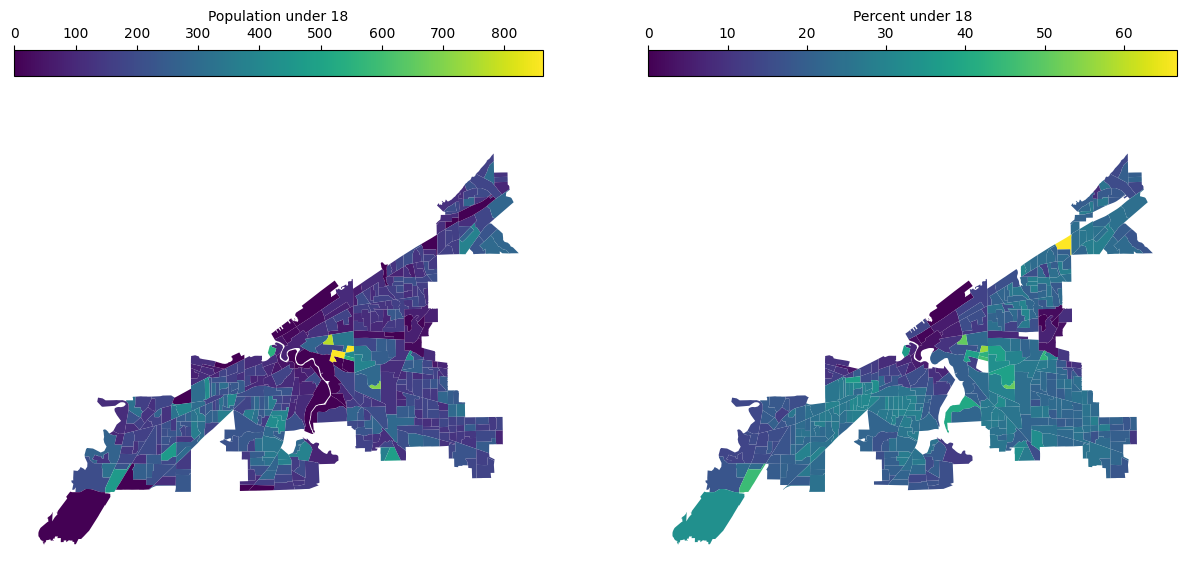

In [50]:
# Before we start mapping across the City, we need to map our universe of data (population under 18) to better understand their distribution across the City.
# It's risky to make assumptions about your data based on polygon areas. The size of an area can be an extremely influential factor in a given metric.
# For example, a tract 10 sq mi. wide could have 500 people. A tract 2 sq. mi wide can have 500 people also. They would show the same on a map!
# We all know the tract 2 sq. mi wide has much more people per space. That's an important element of spatial analysis. Never trust raw counts of numbers until you have controlled for area.
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax1 = cle_bgs.plot(ax=ax[0], column='Population under 18 years', legend = True, legend_kwds={'location': 'top',
                                                                                             'label': 'Population under 18'})
ax2 = cle_bgs.plot(ax=ax[1], column='Percent of population under 18 years', legend = True, legend_kwds={'location': 'top',
                                                                                                        'label': 'Percent under 18'})
for axes in ax:
    axes.set_axis_off()

### Simple Spatial Optimization
#### Looking for the biggest grouping of population under 18 that still doesn't have access to a playground
To find the most effective location (in terms of population under 18), we'll need to find the largest grouping of that population. Our question is, which set of **neighboring** block groups has the **highest** sum of people within that age range? 

In order to do this, we need to define neighboring using a spatial analysis library called `pysal`, which offers functions that check whether shapes touch each other and how.

In [53]:
# Block gruops that don't have access to playground now. These are candidates for assessing optimal location because they can be "gained".
candidate_bgs = cle_bgs[cle_bgs['Playground_flag'] == False]
w_rook = Rook.from_dataframe(candidate_bgs, use_index=False) # Returns an array of neighbors

/home/dns/.pyenv/versions/3.10.12/envs/uai_env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 26 disconnected components.
 There are 12 islands with ids: 0, 27, 28, 48, 52, 57, 58, 92, 98, 102, 103, 105.
  W.__init__(self, neighbors, ids=ids, **kw)


In [54]:
# This code collects the sum of every grouping identified before. It iterates through the list of index values, subsets the dataframe, and sums the < 18 population field for that subset.
population_dict = {}
for bg in w_rook.neighbors.items():
    block_group_id =bg[0]
    neighboring_ids = bg[1]
    cluster_pop = candidate_bgs.iloc[neighboring_ids]['Population under 18 years'].sum()
    # Create new key-value storing that block groups sum
    population_dict[block_group_id] = cluster_pop

In [56]:
# Using the key paramater for max builtin, we can have it fetch each sum from the dictionary (each key). It returns the key of the biggest group per capita.
max_idx = max(population_dict, key=population_dict.get)

<Axes: >

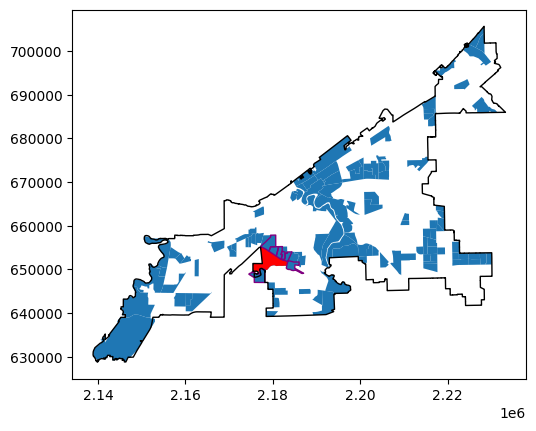

In [58]:
# Plot all candidate block groups, which didn't have access to a Playground
ax = candidate_bgs.plot()

# Plot the optimal location. This block group is it!
candidate_bgs.iloc[[max_idx]].plot(ax=ax, facecolor='red')

# Plot the neighboring tracts of the optimal location tract to visually demonstrate the clustering
candidate_bgs.iloc[w_rook.neighbors[max_idx]].plot(ax=ax, facecolor='none', edgecolor='purple')

# Plot the city boundary for context
city_gdf.plot(ax=ax, edgecolor='black', facecolor='none')